In [1]:
import networkx as nx
import numpy as np
import heapq
import math
import random
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import collections
import time
import psutil
import os

In [2]:
def get_memory_usage():
  process = psutil.Process(os.getpid())
  # return the bytes
  return process.memory_info().rss

Generate Graph with only low doubling dimension:

In [3]:
def generate_low_doubling_dimension_graph(n, dim=2, radius=0.2):
  # choose a low radius => low doubling dimension
  G = nx.random_geometric_graph(n, radius)

  # Get the position dictionary
  pos = nx.get_node_attributes(G, 'pos')

  # Add weights based on Euclidean distances
  for (u, v) in G.edges():
      dist = np.linalg.norm(np.array(pos[u]) - np.array(pos[v]))
      G[u][v]['weight'] = dist

  return G, pos

Generate Random Geometric Graphs with Low Doubling Dimension

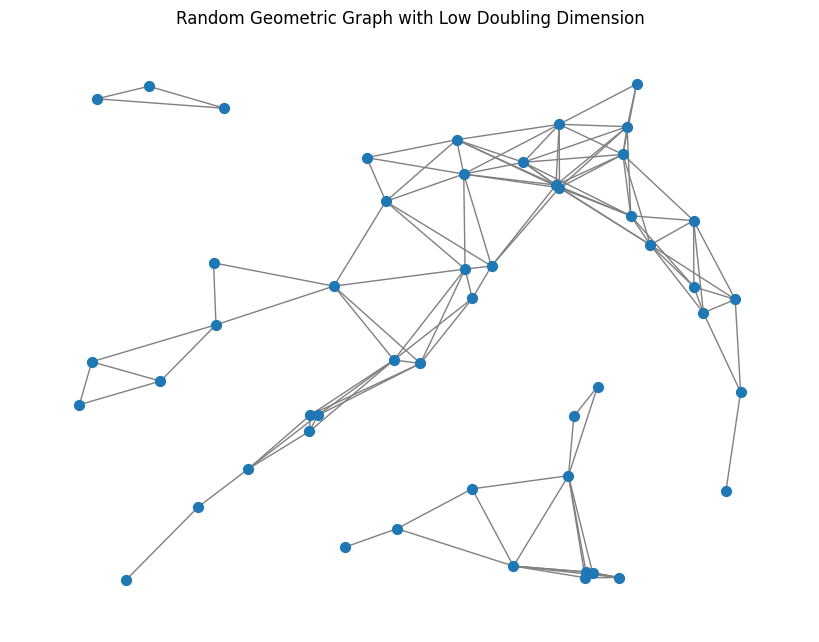

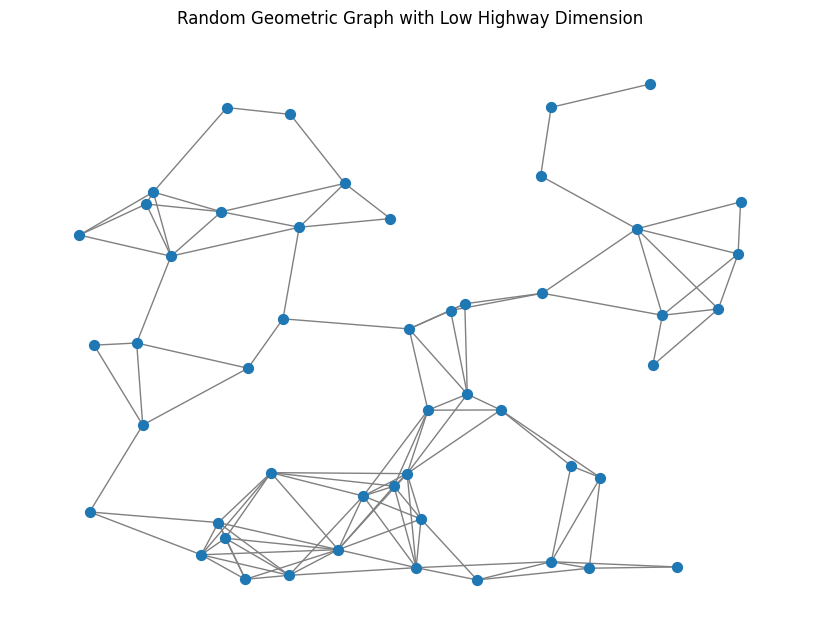

In [4]:
def generate_low_doubling_and_highway_graph(n, dim=2, radius=0.2):
    # generate n random points in a low-dimensional space (low-doubling dimensionality)
    points = np.random.rand(n, dim)

    # create a k-d tree for efficient nearest neighbor search
    tree = cKDTree(points)

    # find all pairs within the radius and connect them to form edges "clustering" locally
    edges = tree.query_pairs(radius)

    # fill the graph nodes with their spatial positions
    G = nx.Graph()
    for i in range(n):
        G.add_node(i, pos=points[i])

    # add node edge pairs found in the k-d search tree
    for u, v in edges:
        # creates natural highways due to sparse long-range paths
        # paths must be connected through key transit nodes
        G.add_edge(u, v)

    # final graph has a highway of nodes connected with clusters amongst transit nodes points
    return G, points

def plot_graph(G, points, lo_doub):
    pos = {i: points[i] for i in range(len(points))}
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=False, node_size=50, edge_color="gray")
    if lo_doub:
        plt.title("Random Geometric Graph with Low Doubling Dimension")
    else:
      plt.title("Random Geometric Graph with Low Highway Dimension")
    plt.show()

# parameters
num_nodes = 50
dimension = 2  # Low dimension ensures low doubling dimension
connection_radius = 0.2

# generate and plot the graph
G, points = generate_low_doubling_dimension_graph(num_nodes, dimension, connection_radius)
plot_graph(G, points, True)
G2, points2 = generate_low_doubling_and_highway_graph(num_nodes, dimension, connection_radius)
plot_graph(G2, points2, False)

Verify that the graphs have low doubling dimension:

In [5]:
def estimate_doubling_constant(G, num_samples=10, r_fraction=0.1):
    nodes = list(G.nodes)
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    # compute approximate max distance in the graph
    max_dist = max(max(d.values()) for d in shortest_path_lengths.values())

    r = int(r_fraction * max_dist)  # set radius as a fraction of max distance
    doubling_constants = []

    for _ in range(num_samples):
        # pick a random node
        center = random.choice(nodes)

        # compute number of nodes within distance r and 2r
        B_r = {node for node, dist in shortest_path_lengths[center].items() if dist <= r}
        B_2r = {node for node, dist in shortest_path_lengths[center].items() if dist <= 2*r}

        if len(B_r) > 0:  # avoid division by zero
            doubling_constants.append(len(B_2r) / len(B_r))

    # compute the estimated doubling constant, values less than 6 == low-doubling dimension
    estimated_C = max(doubling_constants) if doubling_constants else float('inf')

    return estimated_C

Verify Low-Doubling Dimensionality

In [6]:
print(estimate_doubling_constant(G))
G_prime, _ = generate_low_doubling_dimension_graph(50)
print(estimate_doubling_constant(G_prime))

2.6666666666666665
1.0


Function to create the graphs needed in the sample

In [7]:
# create a representitive sample of nodes in the graph for each node sample size
def genGraphSamples(num_nodes, numSamples, lo_hi_lo_doub):
  graphs = []
  for _ in range(numSamples):
    if not lo_hi_lo_doub:
      G, _ = generate_low_doubling_dimension_graph(num_nodes)
      while not nx.is_connected(G) and estimate_doubling_constant(G) > 6:
        G, _ = generate_low_doubling_dimension_graph(num_nodes)
      graphs.append(G)
    else:
      G, _ = generate_low_doubling_and_highway_graph(num_nodes)
      while not nx.is_connected(G) and estimate_doubling_constant(G) > 6:
        G, _ = generate_low_doubling_and_highway_graph(num_nodes)
      graphs.append(G)
  return graphs

Create the sample sets for each node size

In [8]:
def samplesPerNodeSizeDict(lo_hi_lo_doub):
  node_sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
  size_to_samp = collections.defaultdict(list)
  for size in node_sizes:
    graphs = genGraphSamples(size, 10, lo_hi_lo_doub)
    size_to_samp[size] = graphs
  return size_to_samp

Create the representative sample:

In [9]:
sample_dict_lo_hi_lo_doub = samplesPerNodeSizeDict(True)
sample_dict_lo_doub = samplesPerNodeSizeDict(False)

Implement Bi-Di Bellman-Ford.

In [10]:
def bi_bellman_ford(G, s, t):
  start_time = time.time()
  mem_usage = []
  # keep track of the nodes
  nodes = G.nodes

  # keep track of the distances between nodes on the shortest path
  dist_fwd = {node: float('inf') for node in nodes}
  dist_fwd[s] = 0

  dist_back = {node: float('inf') for node in nodes}
  dist_back[t] = 0

  # keep track of how or if we are updating
  # if done updating the algo stops running
  updated_fwd = True
  updated_back = True

  # iterate potentially over all nodes
  for _ in range(len(nodes) - 1):
    mem_usage.append(get_memory_usage())
    if not updated_fwd and not updated_back:
      # if we found the shortest path, iterate no more
      break

    # get ready for a new iteration of updates
    updated_fwd = False
    updated_back = False
    temp_dist_fwd = dist_fwd.copy()
    temp_dist_back = dist_back.copy()

    # check forward edge
    for u, v, weight in G.edges(data='weight'):
      if weight is None:
        continue
      if dist_fwd[u] + weight < temp_dist_fwd[v]:
        # go fwd and check weight fwd
        temp_dist_fwd[v] = dist_fwd[u] + weight
        updated_fwd = True

      # check reverse edge for fwd dist
      if dist_fwd[v] + weight < temp_dist_fwd[u]:
        temp_dist_fwd[u] = dist_fwd[v] + weight
        updated_fwd = True

      if dist_back[u] + weight < temp_dist_back[v]:
        # go from backward and add the weight
        temp_dist_back[v] = dist_back[u] + weight
        updated_back = True

      # check reverse edge from the backward search
      if dist_back[v] + weight < temp_dist_back[u]:
        temp_dist_back[u] = dist_back[v] + weight
        updated_back = True

    # update the forward distances
    dist_fwd = temp_dist_fwd
    # update the backward distances
    dist_back = temp_dist_back

  shortest_path = float('inf')
  for node in nodes:
    if dist_fwd[node] + dist_back[node] < shortest_path:
      # if the fwd dist from source to node + back dist from target to node < shortest_path, update
      shortest_path = dist_fwd[node] + dist_back[node]
  end_time = time.time()

  return shortest_path, (end_time - start_time), np.average(mem_usage)

Implement Bi-Di Dijkstras

In [11]:
def bi_dijkstras(G, s, t):
  start_time = time.time()
  mem_usage = []
  # keep track of the nodes
  nodes = G.nodes

  # keep track of the distance between node pairs from the forward search
  fwd_dist = {node: float('inf') for node in nodes}
  fwd_dist[s] = 0

  # keep track of the distance between node pairs from the backward search
  back_dist = {node: float('inf') for node in nodes}
  back_dist[t] = 0

  fwdHeap = [(0, s)]
  backHeap = [(0, t)]

  mu = float('inf')

  fwd_seen = set()
  back_seen = set()

  while fwdHeap and backHeap:
    mem_usage.append(get_memory_usage())

    if mu <= fwdHeap[0][0] + backHeap[0][0]:
      # found the optimal shortest path
      break

    fwd_dist_node, node = heapq.heappop(fwdHeap)
    if node in fwd_seen:
      # we've already found a shorter path to the node using forward iteration
      continue
    fwd_seen.add(node)

    if fwd_dist_node > mu:
      # if we've found the shortest path stop iteration
      break

    #iterate over neighbors and add them to the heap should there be a shortest path
    for nei in G.neighbors(node):
      weight = G[node][nei].get('weight', None)
      if weight is None:
        continue
      if fwd_dist[node] + weight < fwd_dist[nei]:
        fwd_dist[nei] = fwd_dist[node] + weight
        heapq.heappush(fwdHeap, (fwd_dist[nei], nei))

    back_dist_node, node = heapq.heappop(backHeap)
    if node in back_seen:
      # we've already found a shorter path to the node using backward iteration
      continue

    # mark the current node as seen
    back_seen.add(node)
    if back_dist_node > mu:
      # if we've found the shortest path stop iteration
      break

    # iterate over the neighbors and add them to the heap should there be a shortest path
    for nei in G.neighbors(node):
      weight = G[node][nei].get('weight', None)
      if weight is None:
        continue
      if back_dist[node] + weight < back_dist[nei]:
        back_dist[nei] = back_dist[node] + weight
        heapq.heappush(backHeap, (back_dist[nei], nei))


    mu = min(mu, fwd_dist[node] + back_dist[node])

    end_time = time.time()
    after_mem = get_memory_usage()
  return mu, (end_time - start_time), np.average(mem_usage)

In [12]:
# generated by chatGPT
def plotRuntimeNodes(lo_doub_dict, lo_high_dict):
    node_sizes = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

    results = {"lo_doub_dict": {"bf_time": [], "dij_time": []},
               "lo_high_dict": {"bf_time": [], "dij_time": []}}

    for data_dict, label in [(lo_doub_dict, "lo_doub_dict"), (lo_high_dict, "lo_high_dict")]:
        for size in node_sizes:
            graphs = data_dict[size]
            bellman_ford_times = []
            dijkstras_times = []

            for G in graphs:
                s = random.choice(list(G.nodes))
                t = random.choice(list(G.nodes))

                _, bf_time, _ = bi_bellman_ford(G, s, t)
                bellman_ford_times.append(bf_time)

                _, dij_time, _ = bi_dijkstras(G, s, t)
                dijkstras_times.append(dij_time)

            # store the averages
            results[label]["bf_time"].append(np.mean(bellman_ford_times))
            results[label]["dij_time"].append(np.mean(dijkstras_times))

    # Runtime Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = {"lo_doub_dict": {"bf_time": '#ff0000', "dij_time": '#ffa500'},
              "lo_high_dict": {"bf_time": '#2ca02c', "dij_time": '#98df8a'}}

    ax.set_xlabel("Number of Nodes")
    ax.set_ylabel("Average Runtime (seconds)")

    for label in results:
        ax.plot(node_sizes, results[label]["bf_time"], label=f"{label} BF Runtime", marker="o", color=colors[label]["bf_time"])
        ax.plot(node_sizes, results[label]["dij_time"], label=f"{label} Dijkstra Runtime", marker="s", linestyle="dashed", color=colors[label]["dij_time"])

    ax.legend(loc="upper left")
    ax.grid()

    plt.title("Runtime of Bellman-Ford vs Dijkstra for Lo-Doub and Lo-Hi-Lo-Doub")
    plt.show()


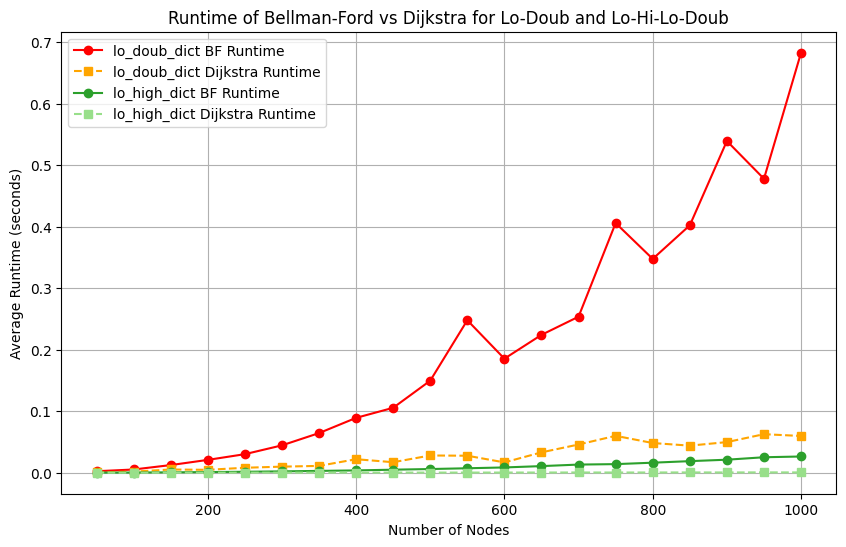

In [ ]:
plotRuntimeNodes(sample_dict_lo_doub, sample_dict_lo_hi_lo_doub)

In [13]:
def plotRuntimeEdges(lo_doub_dict, lo_high_dict):
    edge_counts = sorted(set(len(G.edges) for size in lo_doub_dict for G in lo_doub_dict[size]))

    results = {"lo_doub_dict": {"bf_time": [], "dij_time": []},
               "lo_high_dict": {"bf_time": [], "dij_time": []}}

    for data_dict, label in [(lo_doub_dict, "lo_doub_dict"), (lo_high_dict, "lo_high_dict")]:
        for edge_count in edge_counts:
            bellman_ford_times = []
            dijkstras_times = []

            for size in data_dict:
                for G in data_dict[size]:
                    if len(G.edges) == edge_count:
                        s = random.choice(list(G.nodes))
                        t = random.choice(list(G.nodes))

                        _, bf_time, _ = bi_bellman_ford(G, s, t)
                        bellman_ford_times.append(bf_time)

                        _, dij_time, _ = bi_dijkstras(G, s, t)
                        dijkstras_times.append(dij_time)

            if bellman_ford_times:
                results[label]["bf_time"].append(np.mean(bellman_ford_times))
                results[label]["dij_time"].append(np.mean(dijkstras_times))
            else:
                results[label]["bf_time"].append(None)
                results[label]["dij_time"].append(None)

    # Runtime Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = {"lo_doub_dict": {"bf_time": '#ff0000', "dij_time": '#ffa500'},
              "lo_high_dict": {"bf_time": '#2ca02c', "dij_time": '#98df8a'}}

    ax.set_xlabel("Number of Edges")
    ax.set_ylabel("Average Runtime (seconds)")

    for label in results:
        ax.plot(edge_counts, results[label]["bf_time"], label=f"{label} BF Runtime", marker="o", color=colors[label]["bf_time"])
        ax.plot(edge_counts, results[label]["dij_time"], label=f"{label} Dijkstra Runtime", marker="s", linestyle="dashed", color=colors[label]["dij_time"])

    ax.legend(loc="upper left")
    ax.grid()

    plt.title("Runtime of Bellman-Ford vs Dijkstra based on Edge Count")
    plt.show()


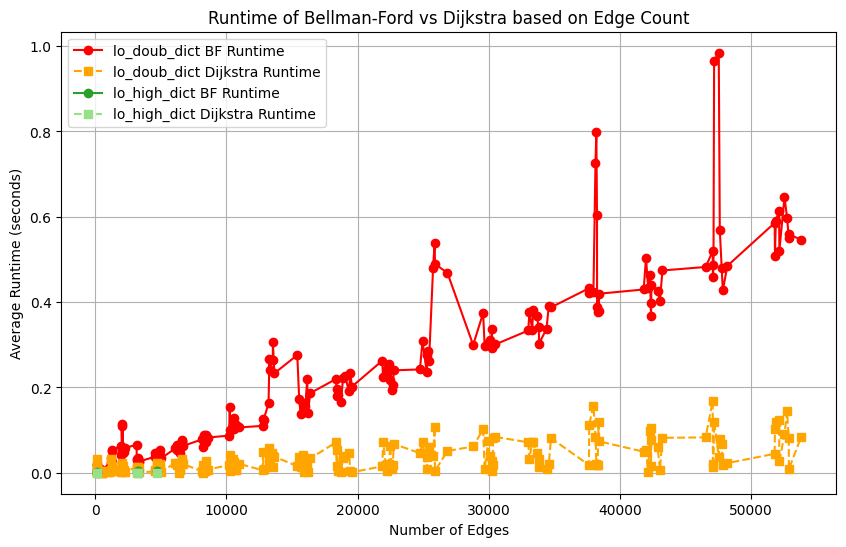

In [14]:
plotRuntimeEdges(sample_dict_lo_doub, sample_dict_lo_hi_lo_doub)

Tester Code for Bi-Di Algos (Tester Code Generated with the help of Google Gemini):

In [ ]:
# Create a simple graph with 5 nodes and some edges
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1, {'weight': 5}), (0, 2, {'weight': 3}), (1, 2, {'weight': 2}), (1, 3, {'weight': 7}), (2, 4, {'weight': 4})])

pos = nx.spring_layout(G)  # Define node positions using spring layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

print(bi_bellman_ford(G, 3, 4))
print(bi_dijkstras(G, 3, 4))

In [ ]:
def generate_random_weighted_graph(num_nodes_min=10, num_nodes_max=30, edge_factor_min=2, edge_factor_max=10, weight_min=1, weight_max=10):
  """Generates a random graph with random edge weights."""
  num_nodes = random.randint(num_nodes_min, num_nodes_max)
  num_edges = random.randint(num_nodes * edge_factor_min, num_nodes * edge_factor_max)

  G = nx.gnm_random_graph(num_nodes, num_edges)

  # Add random weights to edges
  for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(weight_min, weight_max)

  return G
def test():
  G = generate_random_weighted_graph()

  # Generated with Google Gemini:
  pos = nx.spring_layout(G)  # Define node positions using spring layout
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
  edge_labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
  plt.show()
  #end code generation

  source = random.choice(list(G.nodes))
  target = random.choice(list(G.nodes))

  # use the shortest path algo from NX compare against algos
  control_sp = nx.shortest_path_length(G, source=source, target=target, weight='weight')
  bi_bellman_ford_sp = bi_bellman_ford(G, source, target)
  bi_dijkstras_sp = bi_dijkstras(G, source, target)

  print(f"Control Shortest Path: {control_sp}")
  print(f"Bi-Di Bellman-Ford Shortest Path: {bi_bellman_ford_sp}")
  print(f"Bi-Di Dijkstras Shortest Path: {bi_dijkstras_sp}")

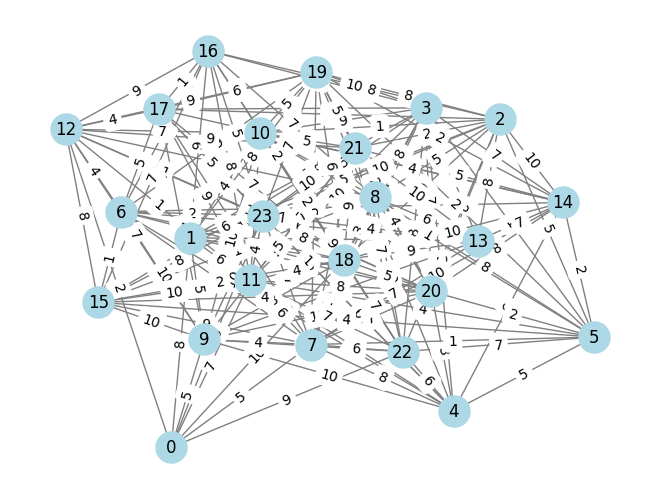

Control Shortest Path: 6
Bi-Di Bellman-Ford Shortest Path: (6, 0.002712726593017578, 159076352.0)
Bi-Di Dijkstras Shortest Path: (6, 0.00048232078552246094, 159076352.0)


In [ ]:
test()